## Accessing OOI Seafloor Camera on Azure

[CamHD](https://oceanobservatories.org/instrument-class/camhd/) is a high-definition video camera connected to the Ocean Observatories Initiative's ([OOI](https://oceanobservatories.org)) fiber optic cable at Axial Seamount and provides data that can support a wide range of oceanographic, biological, and geophysical investigations. Every three hours, the camera scans a hydrothermal vent chimney, imaging the entire chimney over the course of about fifteen minutes.

This notebook shows how to load video data from the [OOI Seafloor Camera](https://oceanobservatories.org/instrument-class/camhd/) system deployed at Axial Volcano on the Juan de Fuca Ridge. It demonstrates the basic usage of the pycamhd library, which can be used to extract frames from the ProRes encoded Quicktime files.

This dataset is stored in the East US Azure region, so this notebook will run most efficiently on Azure compute located in the same region.  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

This dataset is documented at [aka.ms/ai4edata-ooi-camhd](https://aka.ms/ai4edata-ooi-camhd).

### Environment setup

In [2]:
# Standard packages
import numpy as np
import pandas as pd
import fsspec
import time
import datetime
import random
import matplotlib.pyplot as plt
from ipywidgets import interact
from ipywidgets import IntSlider

# Non-standard, but still pip- or conda-installable
import pycamhd as camhd

# .json file containing video metadata
dbcamhd_url = 'https://ooiopendata.blob.core.windows.net/camhd/dbcamhd.json'

### Load the JSON file that lists all available video files
This file has useful information about each file in Azure Open Datasets, such as the Unix timestamp (seconds) of the first frame in each video, and the total number of frames in each video.

In [3]:
with fsspec.open(dbcamhd_url) as f:
    dbcamhd = pd.read_json(f, orient="records", lines=True)
dbcamhd.tail()

,name,url,filesize,md5,moov,timestamp,deployment,frame_count
18745,CAMHDA301-20201201T160000.mov,https://ooiopendata.blob.core.windows.net/camh...,17408035167,9f5d506b42c5fb7f9551622da1ccb733,True,1606837502,7,26947
18746,CAMHDA301-20201201T161500.mov,https://ooiopendata.blob.core.windows.net/camh...,16776728895,129ace733db2f1d48005ae4fe6da7aa3,True,1606838401,7,26995
18747,CAMHDA301-20201201T163000.mov,https://ooiopendata.blob.core.windows.net/camh...,16367647791,7b63f3c29ab0171b72672e96c2362792,True,1606839302,7,26953
18748,CAMHDA301-20201201T164500.mov,https://ooiopendata.blob.core.windows.net/camh...,17174146875,99327a9196ad2196fe4dfb7a3cbc9d8e,True,1606840201,7,26998
18749,CAMHDA301-20201201T170000.mov,https://ooiopendata.blob.core.windows.net/camh...,17121143943,c1ae06d8105b441cb6a313e1539fa885,True,1606841102,7,26964


### Choose a file to work with

In [4]:
# Find files from September 20, 2017...
start_time = datetime.datetime(2017,9,20,0,0,0)
end_time = datetime.datetime(2017,9,21,0,0,0)

start_unixtime = time.mktime(start_time.timetuple())
end_unixtime = time.mktime(end_time.timetuple())

matching_rows = dbcamhd[dbcamhd['timestamp'].between(start_unixtime,end_unixtime)]
matching_rows

,name,url,filesize,md5,moov,timestamp,deployment,frame_count
6994,CAMHDA301-20170920T001500.mov,https://ooiopendata.blob.core.windows.net/camh...,15213499649,af4e281b60a0fccfd94eacbd42b19067,True,1505865602,4,26963
6995,CAMHDA301-20170920T031500.mov,https://ooiopendata.blob.core.windows.net/camh...,15200375781,493f6d8b7ff6f06e05b382337b713531,True,1505876401,4,26990
6996,CAMHDA301-20170920T061500.mov,https://ooiopendata.blob.core.windows.net/camh...,15183872321,f2fbdc2f0cbbf709076bdd70cddf0578,True,1505887201,4,26975
6997,CAMHDA301-20170920T091500.mov,https://ooiopendata.blob.core.windows.net/camh...,15205675185,09fad12381c5bcc15cfa8c8ea67cd81a,True,1505898002,4,26959
6998,CAMHDA301-20170920T121500.mov,https://ooiopendata.blob.core.windows.net/camh...,15229684709,5acd39433f733a77bcc23e16c514008d,True,1505908801,4,26990
6999,CAMHDA301-20170920T151500.mov,https://ooiopendata.blob.core.windows.net/camh...,15220788561,9b2811175b1f4ad48bb74e34d37a6174,True,1505919601,4,26989
7000,CAMHDA301-20170920T181500.mov,https://ooiopendata.blob.core.windows.net/camh...,15250813073,eaadcc47dcaf8c7a94bb5b9708179db8,True,1505930402,4,26953
7001,CAMHDA301-20170920T211500.mov,https://ooiopendata.blob.core.windows.net/camh...,15199072513,7df862c4793e803e086962da67098fb4,True,1505941201,4,26963


In [5]:
# ...and choose the first file from that day.
mov = matching_rows.iloc[0]
mov

name                               CAMHDA301-20170920T001500.mov
url            https://ooiopendata.blob.core.windows.net/camh...
filesize                                             15213499649
md5                             af4e281b60a0fccfd94eacbd42b19067
moov                                                        True
timestamp                                             1505865602
deployment                                                     4
frame_count                                                26963
Name: 6994, dtype: object

### Render one frame from the video

Showing frame 2250


Unknown prores profile 0


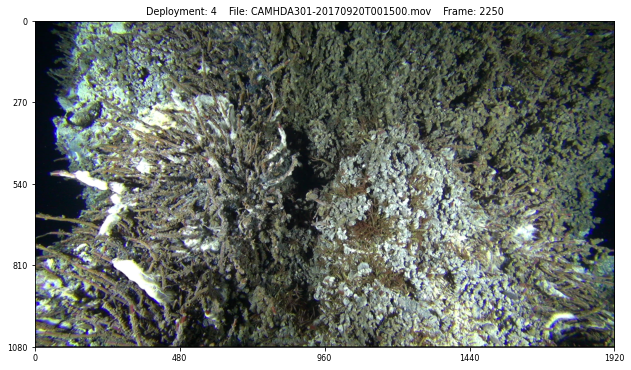

In [6]:
def show_image(frame_number):
    plt.rc('figure', figsize=(12, 6))
    plt.rcParams.update({'font.size': 8})
    frame = camhd.get_frame(mov.url, frame_number)
    fig, ax = plt.subplots();
    im1 = ax.imshow(frame);
    plt.yticks(np.arange(0,1081,270))
    plt.xticks(np.arange(0,1921,480))
    plt.title('Deployment: %s    File: %s    Frame: %s' % (mov.deployment, mov['name'], frame_number));

# Choose a random frame 
initial_frame = random.randrange(0,mov.frame_count)
print('Showing frame {}'.format(initial_frame))
show_image(initial_frame)

### Interactively explore frames from the video
We include a slider which allows any frame from this video to be shown.  If you're viewing an HTML version of this notebook, this cell will look sad, but we swear, the widget you don't see allows you to interactively view frames.

In [7]:
frame_slider = IntSlider(min=0, max=mov.frame_count-1, step=1, value=initial_frame, continuous_update=False)
interact(show_image, frame_number=frame_slider);

interactive(children=(IntSlider(value=2250, continuous_update=False, description='frame_number', max=26962), O…